# Time Series Forecasting 
## Holt Winters Method - Total Construction Spending (United States)

Construction includes the following [[U.S. Census Bureau]](https://www.census.gov/construction/c30/definitions.html). 1. New buildings and structures. 2. Additions, alterations, conversions, expansions, reconstruction, renovations, rehabilitations, and major replacements. 3. Mechanical and electrical installations. 4. Site preparation and outside construction of fixed structures or facilities. 5. Installation of the following types of equipment: boilers, overhead hoists and cranes, and blast furnaces. 6. Fixed, largely site-fabricated equipment not housed in a building. 7. Cost and installation of construction materials placed inside a building and used to support production machinery. Total construction includes the following categories: residential buildings, non-residential buildings, lodging, office, commercial, health care, educational, religious, public safety, amusement and recreation, transportation, communication, power, highway and street, sewage and waste disposal, water supply, conservation and development, manufacturing. Exponential smoothing is a rule of thumb technique for smoothing time series data using the exponential window function [[Wikipedia]](https://en.wikipedia.org/wiki/Exponential_smoothing). Exponential functions are used to assign exponentially decreasing weights over time. Triple exponential smoothing (Holt-Winters method) applies exponential smoothing three times, which is commonly used when there are three high frequency signals to be removed from a time series under study. The method calculates a trend line for the data as well as seasonal indices that weight the values in the trend line based on where that time point falls in the cycle. 

---

Data source: U.S. Census Bureau, Total Construction Spending: Total Construction in the United States [TTLCON], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/TTLCON, March 23, 2022. <br>

Frequency: Monthly <br>
Date range: 2000/01 - 2022/01 <br>
Units: Millions of Dollars, Not Seasonally Adjusted <br>
Updated: Mar 1, 2022

🏷️: <em> STL decompositio, Holt-Winters, forecasting </em>

#### Packages, modules, options and functions

In [1]:
# Packages & modules
import datetime
from pandas import DataFrame, Series
from pandas_datareader import DataReader
from seaborn import color_palette, lineplot
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss 


# Plot parameters
from matplotlib import pyplot, pylab
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')
params = {'figure.titlesize':'medium', 'axes.titlesize':'medium',
          'legend.fontsize': 'x-small', 'legend.title_fontsize': 'x-small',
          'axes.labelsize': 'x-small', 
          'xtick.labelsize':'xx-small', 'ytick.labelsize':'xx-small',
          'figure.dpi':150}
pylab.rcParams.update(params)

### 1. Data preparation

In [2]:
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2022, 1, 1)
data = DataReader('TTLCON', 'fred', start, end)

data = data/1000
data.columns = ['spending']
data.index.names = [None]

data = data.resample('M').max()
print(data.head(5))

            spending
2000-01-31    53.782
2000-02-29    53.993
2000-03-31    61.295
2000-04-30    64.524
2000-05-31    69.253


In [3]:
train = data.head(int(len(data)*0.9)).copy()
test = data.tail(int(len(data)*0.105)).copy()

print(' train end')
print(train.tail(3))
print('')
print(' test start')
print(test.head(3))

 train end
            spending
2019-08-31   131.619
2019-09-30   129.383
2019-10-31   127.326

 test start
            spending
2019-11-30   121.672
2019-12-31   110.530
2020-01-31   104.924


### 2. Data visualization

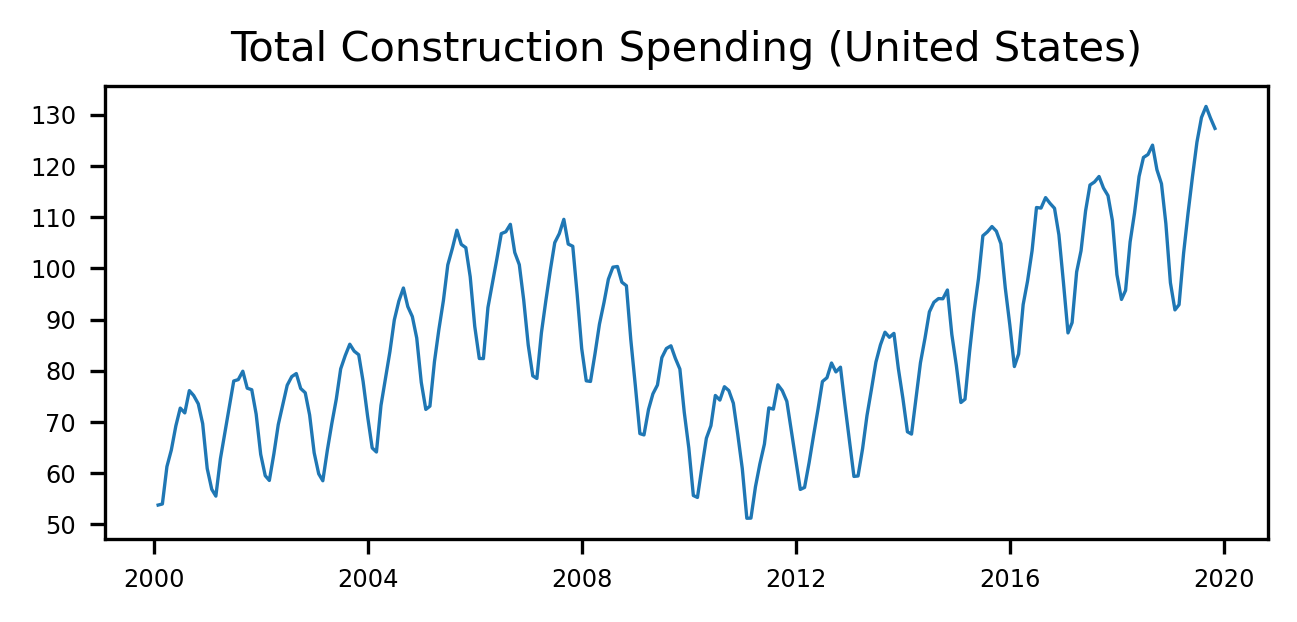

In [4]:
fig, ax = pyplot.subplots(figsize=(5,2))

lineplot(data=train.spending, linewidth=.8)
ax.set_title('Total Construction Spending (United States)')
ax.set_ylabel(None)

pyplot.show()

In [5]:
stl = STL(train.spending).fit()

train['trend'] = stl.trend
train['seasonal'] = stl.seasonal
train['resid'] = stl.resid

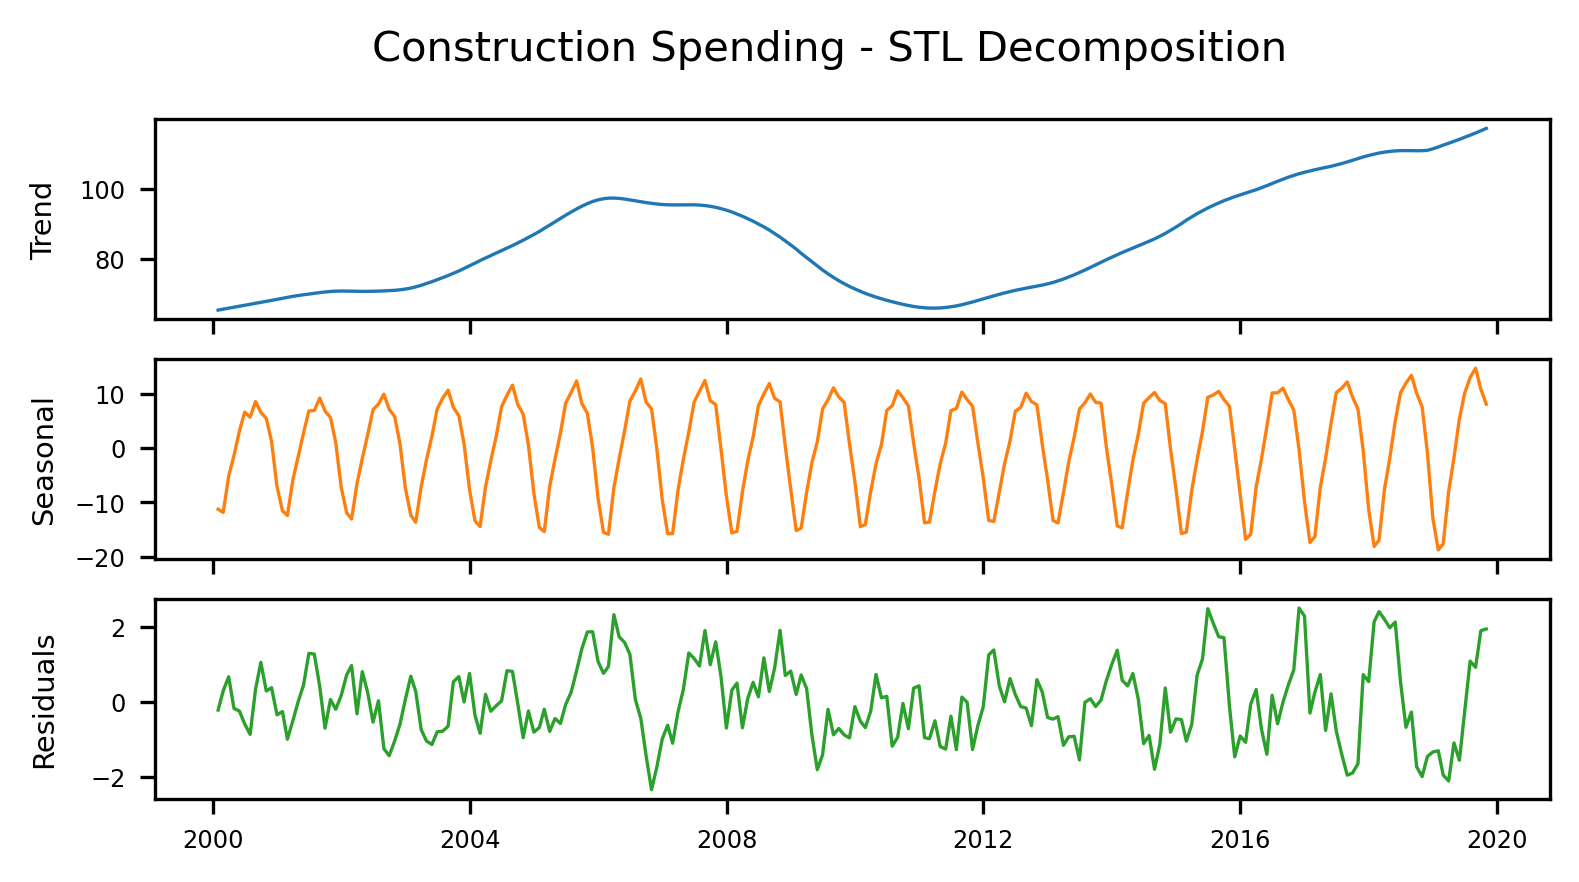

In [6]:
fig, axs = pyplot.subplots(3, 1, figsize=(6,3), sharex=True)

color = color_palette('tab10')
labels = ['Trend', 'Seasonal', 'Residuals']
for i, ax in enumerate(axs.flatten()):
        lineplot(ax=ax, data=train.iloc[:,i+1], linewidth=.8, color=color[i])
        ax.set_ylabel(labels[i])

fig.suptitle('Construction Spending - STL Decomposition')
fig.align_labels()

pyplot.show()

Time series does not look stationary because it exhibits an increasing trend and a seasonal pattern within each year.

In [7]:
print('ADF statistic: %.4f' % adfuller(train.spending)[0])
print('p-value: %.4f' % adfuller(train.spending)[1])
print('KPSS statistic: %.4f' % kpss(train.spending, regression='ct')[0])
print('p-value: %.4f' % kpss(train.spending)[1])

ADF statistic: -0.8558
p-value: 0.8022
KPSS statistic: 0.3151
p-value: 0.0100


p-value of ADF test is larger than 0.05 so the null hypothesis of unit root cannot be rejected. <br>
p-value of KPSS test is less than 0.05 so the null hypothesis of trend-stationarity is rejected. <br>
The series is neither stationary nor trend-stationary.

### 3. Model fitting

Exponential smoothings methods are appropriate for non-stationary data. <br>
Holt-Winters method is used for forecasting time series data that exhibits both a trend and a seasonal variation.

In [8]:
param_grid = {'trend': ['additive', 'multiplicative'], 'damped_trend' : [False], 
                  'seasonal' :['additive', 'multiplicative'], 'seasonal_periods':[12], 
                  'use_boxcox': [True],
                  'smoothing_level': [.1, .2, .3, .4, .5, .6, .7, .8, .9],  
                  'smoothing_trend':[.1, .2, .3, .4, .5, .6, .7, .8, .9],   
                  'smoothing_seasonal': [.1, .2, .3, .4, .5, .6, .7, .8, .9],
                  'damping_trend': [0],   
                  'remove_bias':[False]}

HW_grid = list(ParameterGrid(param_grid))

In [9]:
HW_result = []

for i,j in enumerate(HW_grid):
    trend = j.get('trend')
    damped_trend = j.get('damped_trend')
    seasonal = j.get('seasonal')
    seasonal_periods = j.get('seasonal_periods')
    use_boxcox = j.get('use_boxcox')
    smoothing_level = j.get('smoothing_level')
    smoothing_trend = j.get('smoothing_trend')
    smoothing_seasonal = j.get('smoothing_seasonal')
    damping_trend = j.get('damping_trend')
    remove_bias = j.get('remove_bias') 

    HW = ExponentialSmoothing(train.spending, trend=trend, damped_trend=damped_trend, seasonal=seasonal, seasonal_periods=seasonal_periods, 
                              use_boxcox=use_boxcox)
    
    HW_fit = HW.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, smoothing_seasonal=smoothing_seasonal, 
                    damping_trend=damping_trend, remove_bias=remove_bias, optimized=False)
    
    AIC = HW_fit.aic
    
    HW_result.append({'trend':trend, 'damped_trend':damped_trend, 'seasonal':seasonal, 'seasonal_periods':seasonal_periods, 
                           'use_boxcox':use_boxcox, 
                           'smoothing_level':smoothing_level, 'smoothing_trend':smoothing_trend, 'smoothing_seasonal':smoothing_seasonal, 
                           'damping_trend':damping_trend, 'remove_bias':remove_bias, 
                           'AIC':AIC})

In [10]:
HW_result = DataFrame(HW_result)
HW_result.sort_values(by=['AIC'], ascending=True).head(10)

,trend,damped_trend,seasonal,seasonal_periods,use_boxcox,smoothing_level,smoothing_trend,smoothing_seasonal,damping_trend,remove_bias,AIC
1296,additive,False,additive,12,True,0.9,0.1,0.1,0,False,209.047786
1297,multiplicative,False,additive,12,True,0.9,0.1,0.1,0,False,209.346798
1298,additive,False,additive,12,True,0.9,0.2,0.1,0,False,214.111953
1299,multiplicative,False,additive,12,True,0.9,0.2,0.1,0,False,214.336463
1134,additive,False,additive,12,True,0.8,0.1,0.1,0,False,215.306695
1135,multiplicative,False,additive,12,True,0.8,0.1,0.1,0,False,215.656853
1136,additive,False,additive,12,True,0.8,0.2,0.1,0,False,216.913514
1137,multiplicative,False,additive,12,True,0.8,0.2,0.1,0,False,217.167207
1138,additive,False,additive,12,True,0.8,0.3,0.1,0,False,221.251206
1139,multiplicative,False,additive,12,True,0.8,0.3,0.1,0,False,221.490947


Fit the model with the lowest AIC.

In [11]:
model = ExponentialSmoothing(train.spending, trend='mul', damped_trend=False, seasonal='add', seasonal_periods=12, use_boxcox=True)
holtwinters = model.fit(smoothing_level=.9, smoothing_trend=.1, smoothing_seasonal=.1, damping_trend=0, remove_bias=False, optimized=False)

print(holtwinters.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 spending   No. Observations:                  238
Model:             ExponentialSmoothing   SSE                            501.411
Optimized:                        False   AIC                            209.347
Trend:                   Multiplicative   BIC                            264.903
Seasonal:                      Additive   AICC                           212.470
Seasonal Periods:                    12   Date:                 Fri, 25 Mar 2022
Box-Cox:                           True   Time:                         00:09:05
Box-Cox Coeff.:                 0.07681                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9000000                alpha                False
smoothing_trend          

In [12]:
train['fitted'] = holtwinters.fittedvalues

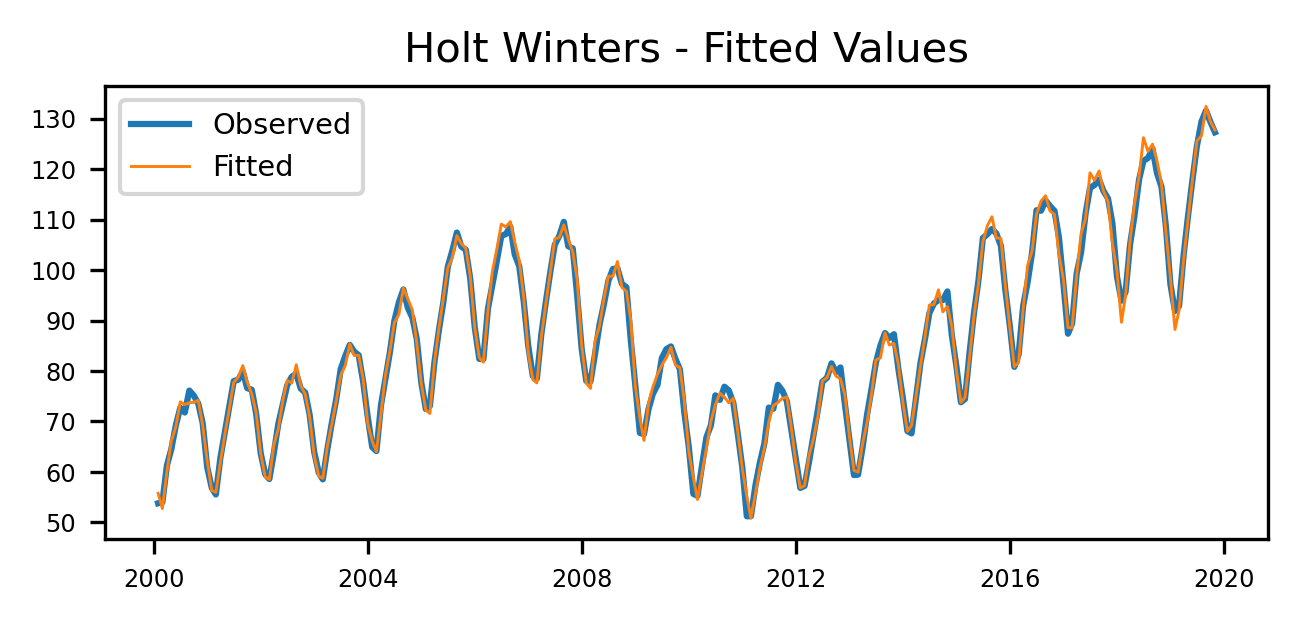

In [13]:
fig, ax = pyplot.subplots(figsize=(5,2))

lineplot(data=train.spending,  label='Observed')
lineplot(data=train.fitted, linewidth=.7, label='Fitted')

ax.set_title('Holt Winters - Fitted Values')
ax.legend(loc='upper left')
ax.set_ylabel(None)
ax.set_xlabel(None)

pyplot.show()

### 4. Forecasting

In [14]:
holtwinters_resid = holtwinters.resid
print(holtwinters_resid.mean())

-0.043491298341998795


The mean of the residuals is very close to zero so the forecasts are unbiased.

In [15]:
test = data.tail(int(len(data)*0.1)).copy()

fcast = Series(holtwinters.predict(start=test.index[0], end=test.index[-1]))
test['forecast'] = fcast

In [16]:
simulations = holtwinters.simulate(nsimulations=len(test)+1, anchor='end', repetitions=100, random_errors="bootstrap")
simulations = simulations[1:]

test['upper'] = simulations.quantile(q=0.95, axis='columns')
test['lower'] = simulations.quantile(q=0.05, axis='columns')

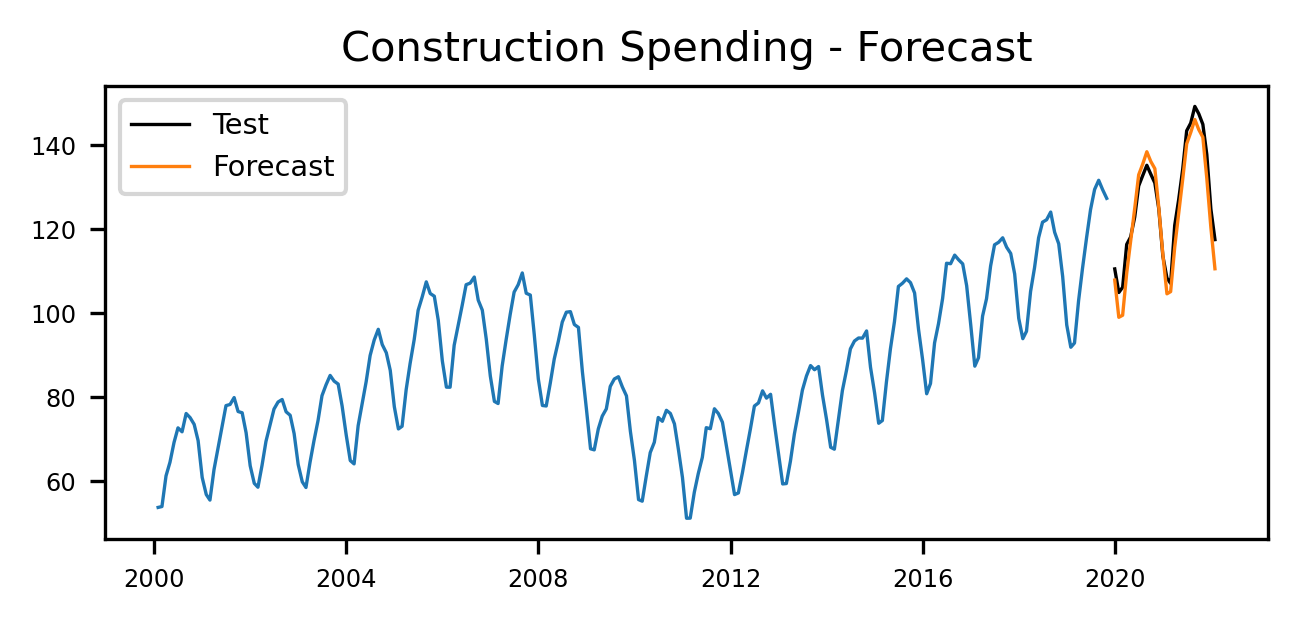

In [17]:
fig, ax = pyplot.subplots(figsize=(5,2))

lineplot(data=train.spending, linewidth=.8)
lineplot(data=test.spending, linewidth=.8, color='black', label='Test')
lineplot(data=test.forecast, linewidth=.8, color='tab:orange', label='Forecast')

ax.set_title('Construction Spending - Forecast')
ax.legend(loc='upper left')
ax.set_ylabel(None)
ax.set_xlabel(None)

pyplot.show()

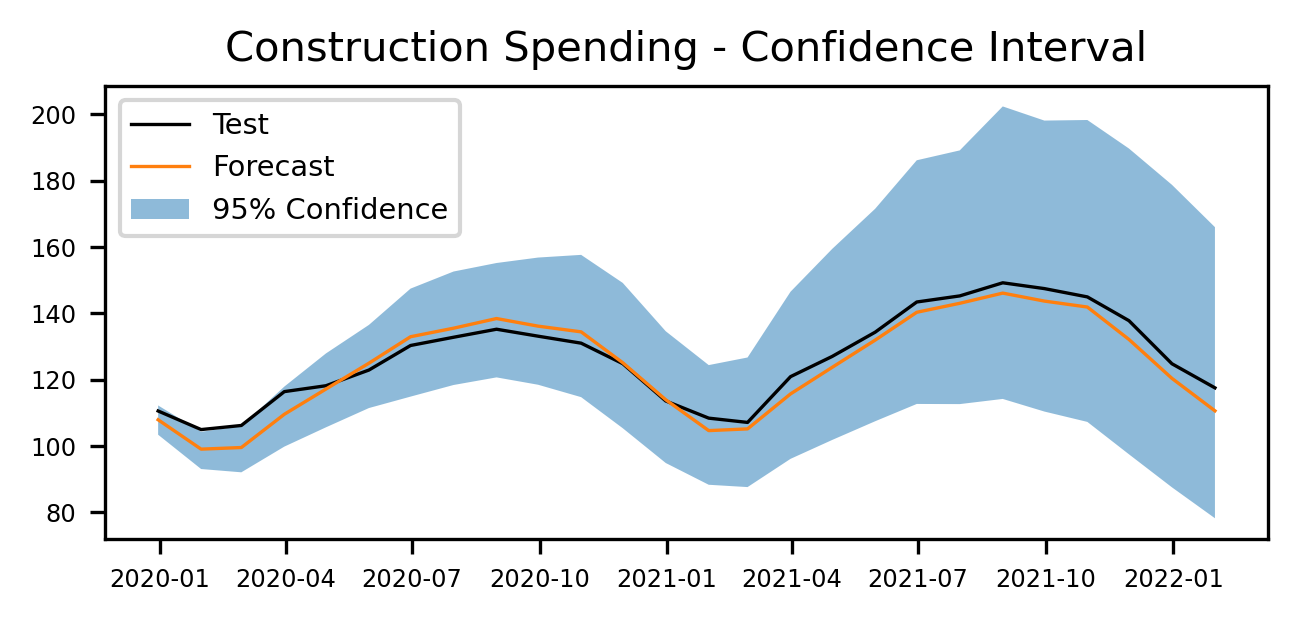

In [18]:
fig, ax = pyplot.subplots(figsize=(5,2))

lineplot(data=test.spending, linewidth=.8, color='black', label='Test')
lineplot(data=test.forecast, linewidth=.8, color='tab:orange', label='Forecast')
ax.fill_between(x=test.index, y1=test.lower, y2=test.upper, 
                alpha=.5, label='95% Confidence')

ax.set_title('Construction Spending - Confidence Interval')
ax.legend(loc='upper left')
ax.set_ylabel(None)
ax.set_xlabel(None)

pyplot.show()

In [19]:
print('RMSE:', round(mean_squared_error(test.spending, test.forecast, squared=False), 4))        
print('MAE:', round(mean_absolute_error(test.spending, test.forecast), 4)) 
print('MAPE:', round(mean_absolute_percentage_error(test.spending, test.forecast), 4))

RMSE: 3.8875
MAE: 3.4487
MAPE: 0.0279


A MAPE equal to 0.0279 means that, on average, the forecast is off by 2.79%